# **Image Captioning**

The process of generating descriptions of the image using pretrained models.

We have opted to use the Encoder - Decoder architecture using CNN and RNN respectively.

Steps include:


*   Data Setup
*   Preprocessing - Tokenization
*   Image feature extraction - Converts images into feature vectors
*   Data Generator - Converts data into smaller batches for efficient processing
*   Build Model with CNN to process feature vector and LSTM to process captions
*   Training
*   **Testing**







## Setup

**Import Data from Kaggle**

In [34]:
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable GPU memory growth to allow dynamic memory allocation
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is enabled.")
    except RuntimeError as e:
        print("Error setting up GPU memory growth:", e)
else:
    print("No GPU detected. Running on CPU.")


GPU is available and memory growth is enabled.


In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


**Import initial libraries**

In [36]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

**Display captions**

In [37]:
data = pd.read_csv(path + "/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

**Display Images**

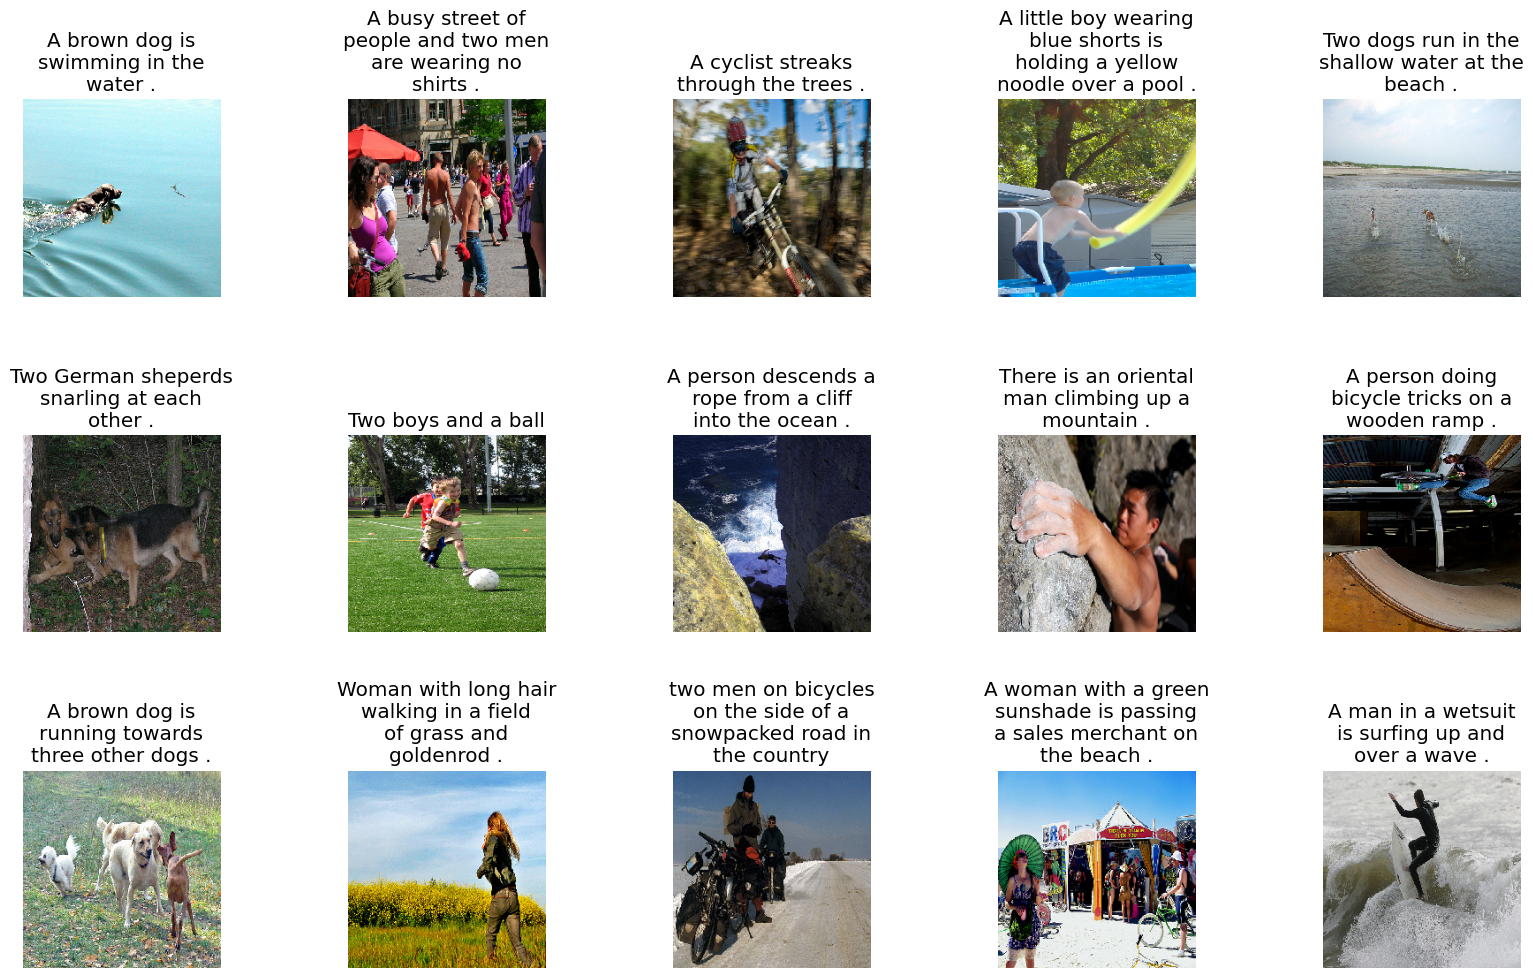

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from textwrap import wrap

image_path = path + "/Images"

def visualizeImages(data):
    data = data.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(image_path+ f"/{data.image[i]}",color_mode='rgb',target_size=(224, 224))
        image = img_to_array(image)
        image = image/255.
        plt.imshow(image)
        plt.title("\n".join(wrap(data.caption[i], 20)))
        plt.axis("off")

visualizeImages(data.sample(15))

## Data Preprocessing
**Caption Preprocessing**



In [39]:
data['caption'] = data['caption'].apply(lambda x: x.lower())
data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
data['caption'] = "startseq "+data['caption']+" endseq"
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

**Tokenization**

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Image Feature Extraction

with batch processing

In [41]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tqdm import tqdm

# Ensure GPU is used for feature extraction
with tf.device('/GPU:0'):
    model = DenseNet201()
    fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
batch_size = 64  # Define batch size for feature extraction
features = {}

def preprocess_images(image_list, img_size, image_path):
    """Preprocess a batch of images."""
    batch_data = []
    for image in image_list:
        img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
        img = img_to_array(img) / 255.0
        batch_data.append(img)
    return np.array(batch_data)

# Split the images into batches
unique_images = data['image'].unique().tolist()
total_batches = len(unique_images) // batch_size + (1 if len(unique_images) % batch_size != 0 else 0)

for i in tqdm(range(total_batches)):
    # Get a batch of image filenames
    batch_images = unique_images[i * batch_size:(i + 1) * batch_size]

    # Preprocess the batch
    batch_data = preprocess_images(batch_images, img_size, image_path)

    # Predict features for the batch
    with tf.device('/GPU:0'):
        batch_features = fe.predict(batch_data, verbose=0)

    # Store the features for each image
    for idx, image in enumerate(batch_images):
        features[image] = batch_features[idx].squeeze()


100%|██████████| 127/127 [01:55<00:00,  1.10it/s]


## Data Generation


In [42]:
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        self.lock = threading.Lock()  # Ensure thread safety

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            with self.lock:  # Lock to ensure thread-safe feature access
                feature = self.features[image].squeeze()

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


In [43]:
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, add, Reshape, concatenate
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

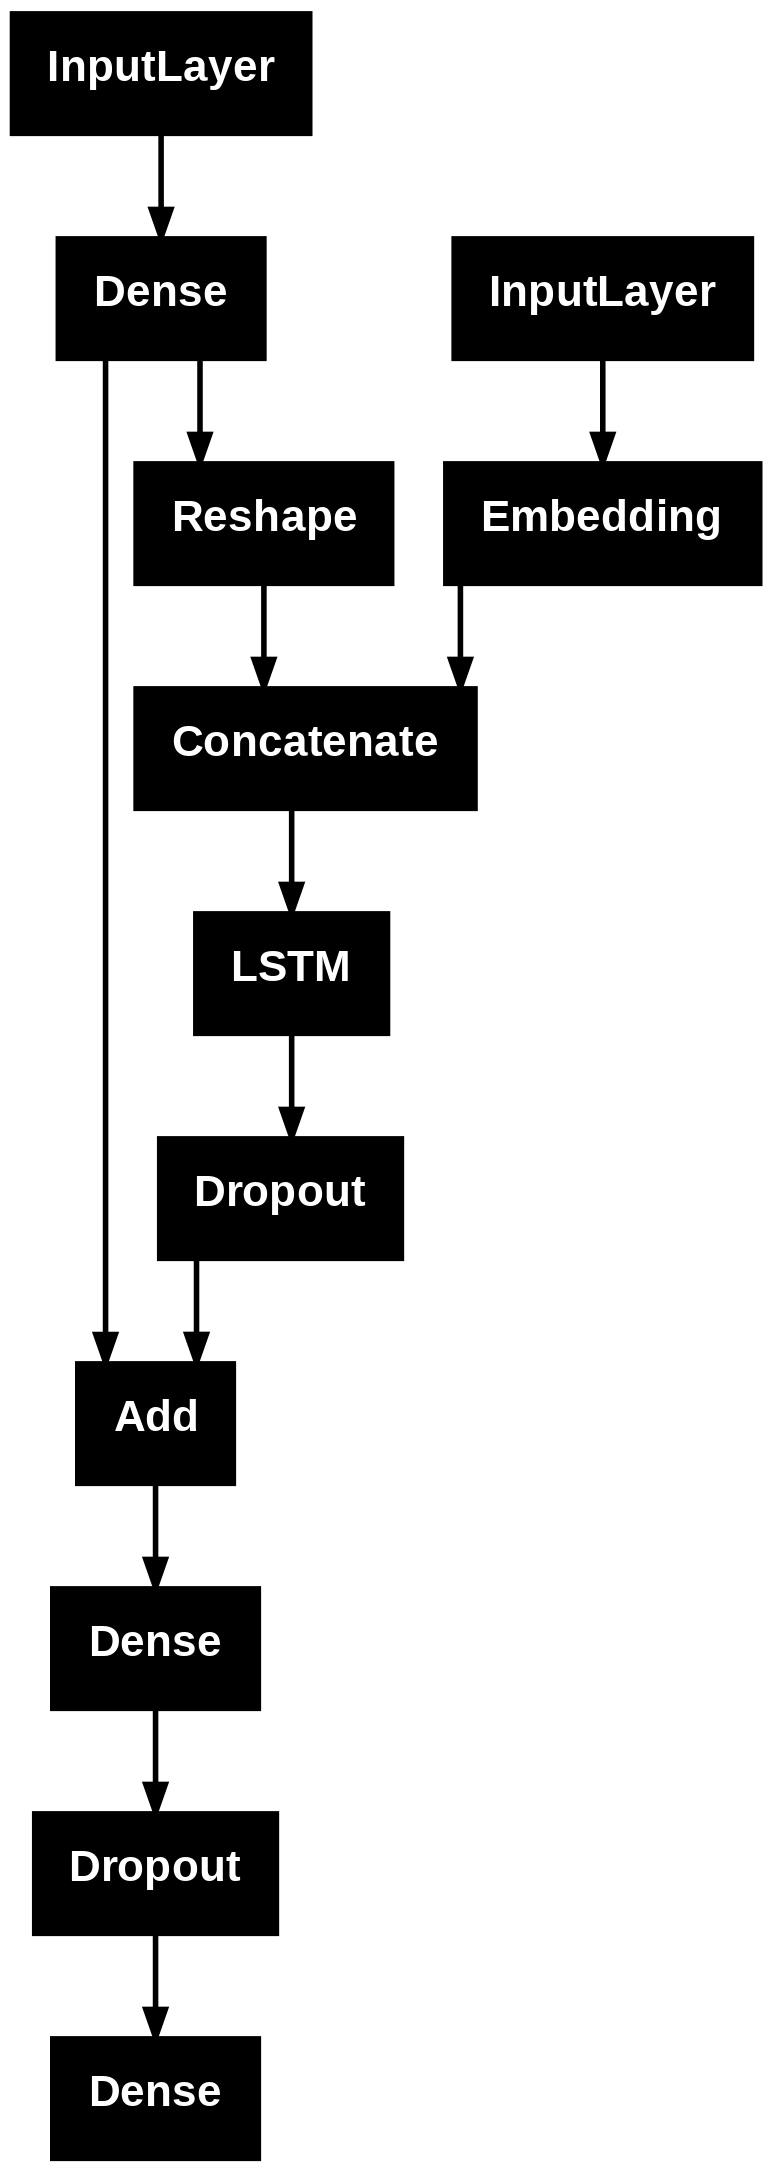

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [45]:
caption_model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        491,776 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35, 256)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import threading

train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

## Training


In [48]:
!nvidia-smi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

with tf.device('/GPU:0'):
    history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
    )

Mon Dec  2 19:47:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |   8321MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

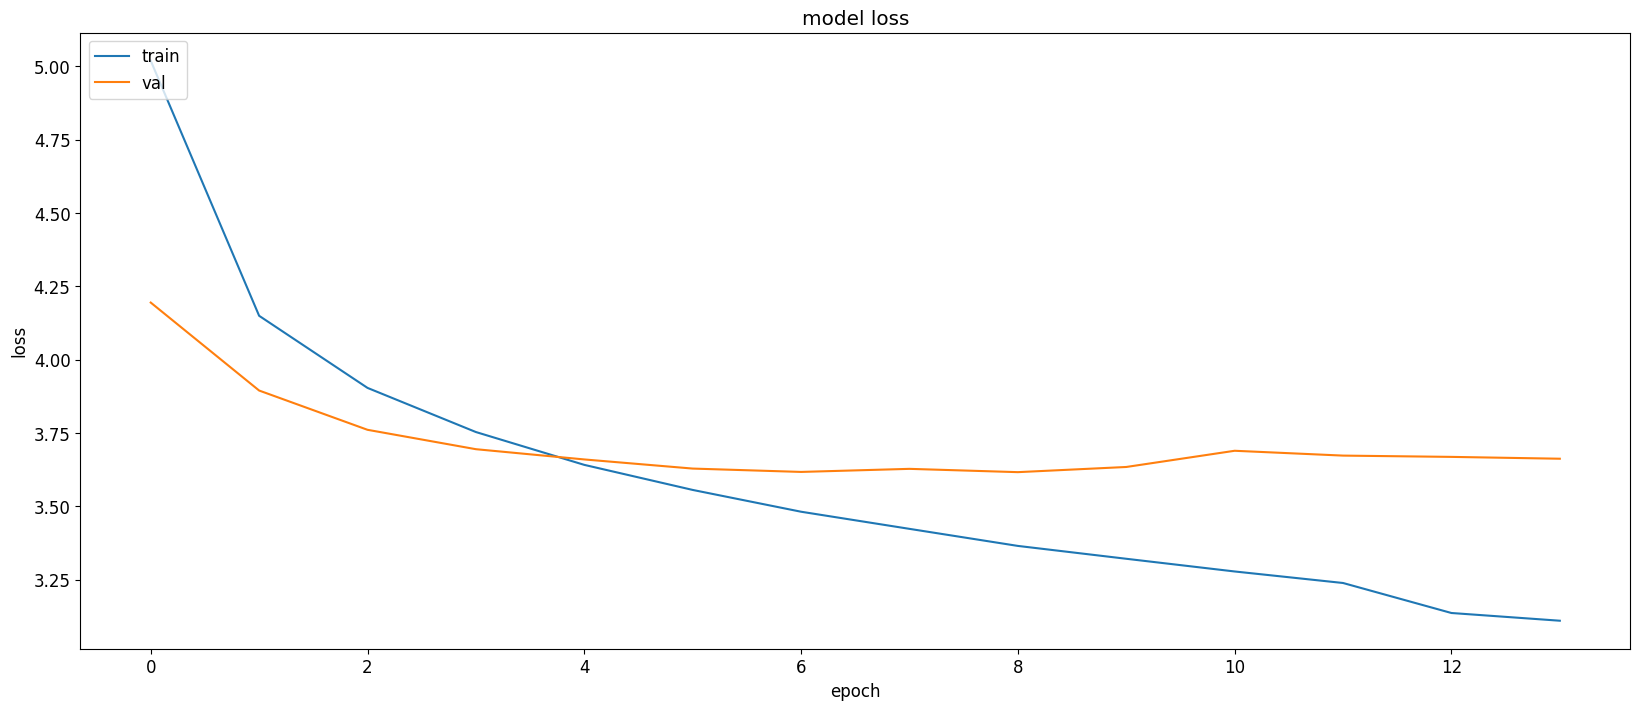

In [49]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [51]:
def predict_caption(model, image, tokenizer, max_length, features):
    # Extract and preprocess the image feature
    feature = features[image].squeeze()  # Ensure feature shape is (1920,)
    feature = np.expand_dims(feature, axis=0)  # Add batch dimension: (1, 1920)

    # Initialize the generated caption
    in_text = "startseq"
    for i in range(max_length):
        # Tokenize and pad the current sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Make a prediction
        y_pred = model.predict([feature, sequence], verbose=0)  # Disable verbose for speed
        y_pred = np.argmax(y_pred)  # Get the index of the most probable word

        # Convert the predicted index to a word
        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        # Append the word to the sequence
        in_text += " " + word

        # Stop if the model predicts the end sequence token
        if word == 'endseq':
            break

    return in_text

# Helper function to map token index to a word
def idx_to_word(index, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return None


In [52]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [53]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

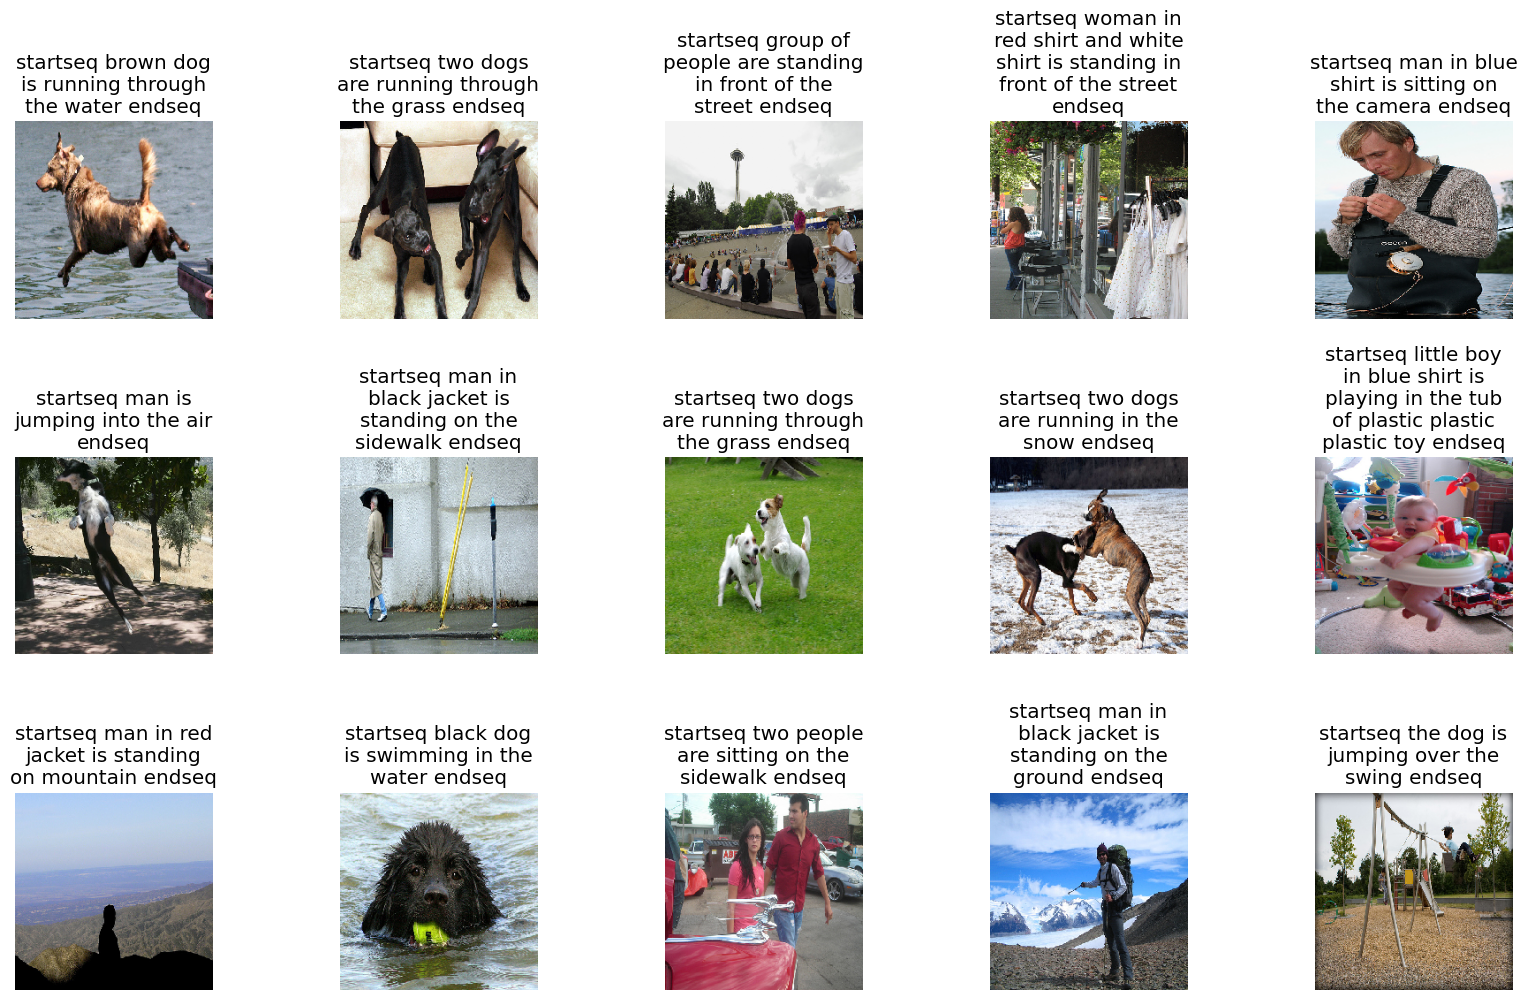

In [54]:
visualizeImages(samples)